In [32]:
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test set does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [35]:
class MyDataset(Dataset):
    def __init__(self, path, df, transforms):
        self.path = path
        self.df = df
        self.len = len(df)
        self.transforms = transforms
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        im_path = self.df['Path'].iloc[index]
        image_transforms['train']
        img = cv2.imread(self.path+im_path)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = self.transforms(img)
        label = self.df['ClassId'].iloc[index]
        return img, label

In [36]:
small_train_df = pd.read_csv('../../GTSRB/Train.csv')
small_train_df = small_train_df[small_train_df['ClassId']<10]
small_train_df = small_train_df[(small_train_df['Path'].str[-6:-4].astype(int))>25]

In [37]:
path = '../../GTSRB/'
small_train_dataset = MyDataset(path, small_train_df, image_transforms['train'])
small_train_loader = DataLoader(small_train_dataset, batch_size=20, shuffle=True)

In [38]:
res3_model = resnet50(pretrained=True)

In [39]:
#freeze weights
for param in res3_model.parameters():
    param.requires_grad = False

In [40]:
in_features = res3_model.fc.in_features
in_features

2048

In [41]:
res3_model.fc = nn.Linear(in_features, 10)
#     nn.ReLU(),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Linear(128, 10))

In [42]:
res3_model.to(device);

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res3_model.parameters(), lr=.005)

In [44]:
n_epochs = 7
train_loss = []
train_acc = []
for epoch in range(n_epochs):
    running_loss = 0
    running_correct = 0
    for data, targets in small_train_loader:
        data = data.to(device)
        targets = targets.to(device)
        # Generate predictions
        outputs = res3_model(data)
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Loss and accuracy calc
        preds = torch.argmax(outputs, axis=1)
        running_loss += loss.item()
        running_correct += torch.sum(preds == targets.data)
    epoch_loss = running_loss/len(small_train_loader.dataset)
    epoch_acc = running_correct.float()/ len(small_train_loader.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

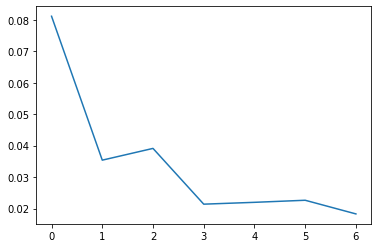

In [45]:
plt.plot(train_loss)

tensor(0.8788, device='cuda:0')

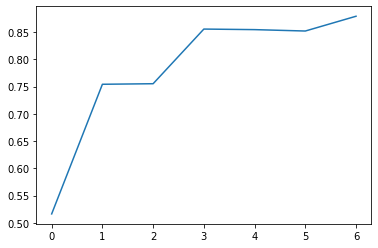

In [46]:
plt.plot(train_acc)
train_acc[-1]

In [47]:
res3_model.eval();

In [48]:
small_test_df = pd.read_csv('../../GTSRB/Test.csv')
small_test_df = small_test_df[small_test_df['ClassId']<10]
small_test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
1,42,45,5,5,36,40,1,Test/00001.png
11,45,44,6,5,40,39,7,Test/00011.png
13,36,37,5,6,31,32,7,Test/00013.png
14,43,41,5,5,37,36,4,Test/00014.png
15,27,27,6,6,22,22,9,Test/00015.png


In [49]:
small_test_dataset = MyDataset(path, small_test_df.iloc[:200], image_transforms['test'])
small_test_loader = DataLoader(small_test_dataset, shuffle=False)

In [50]:
correct = 0
for data, target in small_test_loader:
    data = data.to(device)
    target = target.to(device)
    preds = res3_model(data)
    preds = torch.argmax(preds, axis=1)
    correct += torch.sum(preds==target.data)
    
correct.item()/len(small_test_loader.dataset)

0.53